In [9]:
library(Seurat)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(SeuratDisk)
library(RColorBrewer)
library(stringr)
library(patchwork)
library('reshape2')
source("/root/workspace/sjh/code/Compare/MIDAS/utils/utils_process.R")

library("IRdisplay")
display_html("<style>.container { width:100% !important; }</style>")


In [10]:
# task <- c("10", "20", "50", "100")
task <- c("100")
experiment <- c("all")
# experiment <- c("all", "all_mix", "null")
# experiment <- c("H", "H_mask+subsample", "H_mask+noise", "Null model")
inputdir <- "/root/workspace/sjh/data/paper/result"

In [11]:
b_cols <- c("#8dd3c7","#ffffb3","#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5","#d9d9d9","#bc80bd","#ccebc5","#ffed6f")
cell_types <- c("T prog cycling", "T reg", "Reticulocyte", "B", "CD4+ T", "CD8+ T", "Unconventional T", "Erythroblast", "G/M prog", 
                "MK/E prog", "Lymph prog", "Mono", "HSC", "ILC", "Normoblast", "Plasma cell", "Plasmablast", "cDC", "pDC", "Unselected")
colors <- c("#FDDD8D", "#E3CDDA", "#FEF4C9", "#F2B6B4", "#B0CAC7", "#F9D8AA", "#CDD796", "#C4AFD2", "#74ADD1", 
            "#98B994", "#EEEDBC", "#AEC7E8", "#FCA95E", "#D3D8D7", "#9189A5", "#C8DCCC", "#C2ABC0", "#A5B8B3", 
            "#E6B9A2", "#E5E5E5")
c_cols <- setNames(colors, cell_types)

In [12]:
q <- list()
qpl = 1
for (T in task) {   
    p <- list()
    pl = 1

    config <- parseTOML(pj(inputdir, "../configs/data.toml"))[[paste0("bmmc_sub", T)]]
    subset_ids <- seq(0, length(config$s_joint)-1)

    labels = data.frame()
    batches = data.frame()
    labels_dir <- pj("/dev/shm/processed/", paste0("bmmc_sub", T), paste0("subset_", subset_ids), "labels.csv")

    i = 0
    for (l in labels_dir) {
        df <- read.csv(l)
        labels <- rbind(labels, df)
        i_ <- gsub("^0$", "s1d1",
              gsub("^1$", "s1d2",
              gsub("^2$", "s1d3",
              gsub("^3$", "s2d1", 
              gsub("^4$", "s2d4", 
              gsub("^5$", "s2d5", 
              gsub("^6$", "s3d1", 
              gsub("^7$", "s3d6", 
              gsub("^8$", "s3d7", 
              gsub("^9$", "s4d1", 
              gsub("^10$", "s4d8", 
              gsub("^11$", "s4d9", i))))))))))))
        batches <- rbind(batches, data.frame(batch = rep(i_, nrow(df))))
        i = i + 1
    }

    for (E in experiment) {
        print(E)
        input_dirs <-pj(inputdir, paste0("bmmc_sub", T), E, "default", "predict", "sp_00000799", paste0("subset_", subset_ids))

        #Load model outputs
        z <- list()
        for (i in subset_ids + 1) {
            z_dir  <- pj(input_dirs[i], "z", "joint")
            fnames <- dir(path = z_dir, pattern = ".csv$")
            fnames <- str_sort(fnames, decreasing = F)
            z_subset <- list()
            for (n in seq_along(fnames)) {
                if (file.exists(file.path(z_dir, fnames[n]))) {
                z_subset[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
                }
            }
            z[[i]] <- bind_rows(z_subset)
        }
        all_z <- data.matrix(bind_rows(z))
        all_c <- all_z[,1:32]
        all_b <- all_z[,33:34]

        rownames(all_c) <- as.character(seq(1, nrow(all_c), 1))
        encoder_c <- CreateSeuratObject(t(all_c))
        encoder_c@meta.data$cell_types <- labels$celltype.l1
        encoder_c@meta.data$batch <- batches$batch

        encoder_c[['emb']] <- CreateDimReducObject(embeddings = as.matrix(all_c), key = 'emb')
        
        if (ncol(all_c) < 32) {dim_c = ncol(all_c)}
        else {dim_c = 32}
        encoder_c <- RunUMAP(object = encoder_c, reduction = 'emb', dims = 1:dim_c)

        rownames(all_b) <- as.character(seq(1, nrow(all_b), 1))
        encoder_b <- CreateSeuratObject(t(all_b))
        encoder_b@meta.data$cell_types <- labels$celltype.l1
        encoder_b@meta.data$batch <- batches$batch

        encoder_b[['emb']] <- CreateDimReducObject(embeddings = as.matrix(all_b), key = 'emb')
        encoder_b <- RunUMAP(object = encoder_b, reduction = 'emb', dims = 1:2, metric = "euclidean")

        # c
        # if (pl == 1){
        #     pcc <- DimPlot(encoder_c, group.by = "cell_types", cols = c_cols, pt.size = 0.001) + NoLegend() +
        #                 ylab(paste0("Subset ", T, "%")) + theme(panel.border = element_rect(color = "black", linewidth = 1), 
        #                     axis.title.y = element_text(size = 14, face = "bold"), axis.ticks = element_blank(), axis.text = element_blank(), 
        #                     axis.title.x = element_blank(), plot.margin = margin(0, 0, 0, 0))
        # }
        # else{
            pcc <- DimPlot(encoder_c, group.by = "cell_types", cols = c_cols, pt.size = 0.001, shuffle = TRUE) + NoLegend() + 
                        theme(panel.border = element_rect(color = "black", linewidth = 1), axis.title = element_blank(), 
                            axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 0, 0, 0))
        # }

        # b
        # pbc <- DimPlot(encoder_b, group.by = "cell_types", cols = c_cols, pt.size = 0.001, shuffle = TRUE) + 
        #             theme(panel.border = element_rect(color = "black", linewidth = 1), axis.title = element_blank(), 
        #                 axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 10, 0, 0))

        # if (qpl == 1){
        #     pcc <- pcc + ggtitle('latent biological states')
        #     pbc <- pbc + ggtitle('latent technical noise')
        # }
        # else{
            # pcc <- pcc + ggtitle('')
            # pbc <- pbc + ggtitle('')
        # }

        pcb <- DimPlot(encoder_c, group.by = "batch", cols = b_cols, pt.size = 0.001) + NoLegend() + 
                    theme(panel.border = element_rect(color = "black", linewidth = 1), , axis.title = element_blank(), 
                    axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 0, 20, 0)) + ggtitle('')
        # A <- DimPlot(encoder_c, group.by = "batch", cols = b_cols, pt.size = 0.001, split.by = "batch")
        
        # pbb <- DimPlot(encoder_b, group.by = "batch", cols = b_cols, pt.size = 0.001) + 
        #             theme(panel.border = element_rect(color = "black", linewidth = 1), , axis.title = element_blank(), 
        #             axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 10, 20, 0)) + ggtitle('')
        
        # if (qpl == 1 & pl == 3){
            # pbc <- pbc + theme(legend.position = "right", legend.text = element_text(size = 16)) + guides(color = guide_legend(ncol = 2, override.aes = list(size = 4)))
            # pbb <- pbb + theme(legend.position = "right", legend.text = element_text(size = 16)) + guides(color = guide_legend(ncol = 2, override.aes = list(size = 4)))
        # }
        # else{
        #     pbc <- pbc +  NoLegend()
        #     pbb <- pbb + NoLegend()
        # }

        # p[[pl]] <- (pcc | pbc) / (pcb | pbb) + plot_layout(ncol = 1, heights = c(1, 1))
        p[[pl]] <- pcc | pcb + plot_layout(nrow = 1, heights = c(1, 1))
        pl = pl + 1      
    }

    # q[[qpl]]  <- p[[1]] | p[[2]] | p[[3]]
    q[[qpl]]  <- p[[1]]
    qpl = qpl + 1
}

[1] "all"


Warning message:
"No assay specified, setting assay as RNA by default."
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_"
08:12:48 UMAP embedding parameters a = 0.9922 b = 1.112

08:12:48 Read 75195 rows and found 32 numeric columns

08:12:48 Using Annoy for neighbor search, n_neighbors = 30

08:12:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:12:56 Writing NN index file to temp file /tmp/RtmpfLAxB1/file146ca130edc76

08:12:56 Searching Annoy index using 1 thread, search_k = 3000

08:13:21 Annoy recall = 100%

08:13:22 Commencing smooth kNN distance calibration us

In [13]:
# options(repr.plot.width = 19, repr.plot.height = 3)
# A

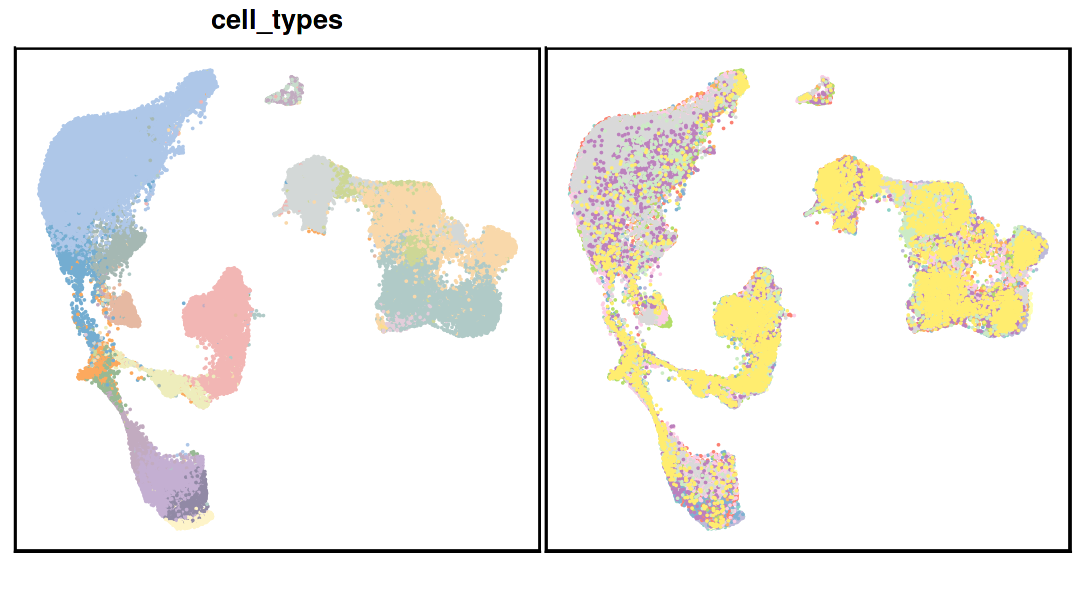

In [18]:
# options(repr.plot.width = 21, repr.plot.height = 23)
# Q <- q[[1]] / q[[2]] / q[[3]] / q[[4]]
options(repr.plot.width = 9, repr.plot.height = 5)
Q <- q[[1]]
Q

In [21]:
ggsave("figure4_01.png", Q, dpi = 300, width = 9, height = 5)